# Detecting fake news: binary classification of fake vs. true news based on textual characteristics of news articles
By Sarah Gauthier, Jessie Liang and Vinay Valson 2025-11-19

**Note**: The model fitting code runs up to 5 minutes.

In [18]:
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import(
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
# import altair as alt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from scipy.stats import expon, lognorm, loguniform, randint, uniform, norm, randint
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, classification_report
import pandera.pandas as pa

## Summary

News is everywhere. In this digital era, there exists both true and fake news on the Internet, making it harder for readers and news agents to differentiate them. So, fake news detection is a technology with rising demands that helps defend information integrity. To solve this problem, applied machine learning is used for binary classification. The fitted Naive Bayes model with `MultinomialNB` as estimator and `title`, `text` and `subject` as features yields a test classification accuracy of 0.954, where the false positive and false negative rates are both low. The AP score and AUC value of the final model end up being 0.97 and 0.98 respectively, suggesting decent and satisfactory performance. Compared to the baseline dummy classifier, this Naive Bayes model classifies both true and fake news significantly better, which is reflected by consistently high and similar training, cross-validation and test scores. This machine learning model gives us confidence in its decent performance, which can potentially be deployed and used in the reality. But limitations do exist, since the collected data do not cover all possible types of news. So, when deployed in the wild, the model might perform badly in news of other realms, such as entertainment news. If more comprehensive data can be collected, then this model might handle more cases accurately.

## Introduction

"Fake news", also known as disinformation, is deliberately misleading or false information presented as legitimate news (Service Canada, 2024). Its rapid spread in recent years has becoming a pressing concern, particularly with the rise of social media platforms that accelerate the dissemination of content. These platforms are designed with the primary objective of capturing and retaining user attention for as long as possible. To that end, fake news often exploits this design to gain traction.

There is high public awareness of this issue in Canada. In 2023, Statistics Canada reported that 59% of Canadians admitted that they were "very or extremely concerned about online misinformation" in the Survey Series on People and their Communities (Bilodeau and Khalid, 2024). In the United States, the concept of "fake news" grew in popularity during the 2016 presidential election. Allcott and Gentzkow (2017) estimated that false news stories were shared on Facebook at least 38 million times in the 3 months leading up to the election. Such widespread circulation of this false information can have serious consequences, including influencing public opinion and undermining trust in legitimate news sources. Thus, methods for detecting fake news may be beneficial in mitigating its spread.

This report investigates whether a machine learning model can accurately classify news articles as "fake" or "true" based on their textual characteristics, such as the article's title, subject and body content. Automated detection of fake news has the potential to mitigate the spread and impact of information, particularly in social media's fast-paced environment where information is shared instantly and at scale, from numerous sources.

## Data

The dataset used in this analysis is the "Fake and Real News Dataset" available on Kaggle, [here](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset). It contains approximately 40,000 news articles published in the United States between 2015 and 2018. Each row in the dataset represents a news article, with a column for its title, subject, date, and body text.

The raw data from Kaggle was split into two datasets: one for the fake articles and one for the true articles. To prepare the data for modeling, we combined both datasets into one large one, with an added column for the `target` value. We then shuffled the rows and split the data into training (80%) and testing (20%) sets.

In [19]:
true_url = "../data/True.csv" 
fake_url = "../data/Fake.csv"

# Check if file format is .csv
if not (true_url.lower().endswith(".csv") and fake_url.lower().endswith(".csv")):
    raise ValueError("Data file must be in .csv format.")

# Read in data from .csv files
true_df = pd.read_csv(true_url)
fake_df = pd.read_csv(fake_url)

In [20]:
true_df['target'] = 'True'
true_df['subject'] = true_df['subject'].replace('politicsNews', 'political')
true_df['subject'] = true_df['subject'].replace('worldnews', 'non-political')
true_df.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,political,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,political,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,political,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,political,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,political,"December 29, 2017",True


In [21]:
fake_df['target'] = 'Fake'
fake_df['subject'] = fake_df['subject'].replace('politics', 'political')
fake_df['subject'] = fake_df['subject'].replace('left-news', 'political')
fake_df['subject'] = fake_df['subject'].replace('Government News', 'political')
fake_df['subject'] = fake_df['subject'].replace('News', 'non-political')
fake_df['subject'] = fake_df['subject'].replace('US_News', 'non-political')
fake_df['subject'] = fake_df['subject'].replace('Middle-east', 'non-political')
fake_df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,non-political,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,non-political,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",non-political,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",non-political,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,non-political,"December 25, 2017",Fake


#### Data Validation

**Part 1**: Perform the following data validation checks:
- Correct column names
- No empty observations
- Missingness not beyond expected threshold
- Correct data types in each column
- No duplicate observations

In [22]:
true_df = true_df.drop_duplicates()

schema = pa.DataFrameSchema(
    {
        "title": pa.Column(str),
        "text": pa.Column(str),
        "subject": pa.Column(str,
                             pa.Check(lambda s: s.isna().mean() <= 0.05,
                                      element_wise=False,
                                      error = "Too many null values in 'subject' column")),
        "date": pa.Column(str, nullable=True),
    },
    checks = [
        pa.Check(lambda df: ~df.duplicated().any(), error = "Duplicate rows found."),
        pa.Check(lambda df: ~(df.isna().all(axis=1)).any(), error = "Empty rows found.")
    ],
    drop_invalid_rows=True
)

schema.validate(true_df, lazy=True)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,political,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,political,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,political,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,political,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,political,"December 29, 2017",True
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,non-political,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",non-political,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,non-political,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,non-political,"August 22, 2017",True


In [23]:
fake_df = fake_df.drop_duplicates()
schema.validate(fake_df, lazy=True)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,non-political,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,non-political,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",non-political,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",non-political,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,non-political,"December 25, 2017",Fake
...,...,...,...,...,...
22698,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,non-political,"January 7, 2016",Fake
22699,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,non-political,"January 7, 2016",Fake
22700,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,non-political,"January 6, 2016",Fake
22701,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,non-political,"January 4, 2016",Fake


**Part 2**: Perform the following data validation checks on `true_df` and `fake_df`:
- No outlier or anomalous values
- Correct category levels (i.e., no string mismatches or single values)

In [24]:
schema2 = pa.DataFrameSchema(
    {
        "title": pa.Column(
            str,
            pa.Check((lambda x: x.str.len().between(5, 1000)), 
                     error="Outlier title length detected")
        ),
        "text": pa.Column(
            str,
            pa.Check((lambda x: x.str.len().between(20, 80000)), 
                     error="Outlier text length detected")
        ),
        "subject": pa.Column(
            str,
            pa.Check((lambda x: x.isin(['political', 'non-political'])),
                     error="Incorrect subject category levels")
        ),
        "date": pa.Column(
            str,
            pa.Check((lambda x: pd.to_datetime(x,
                                              format='mixed',
                                              errors='coerce').between(pd.Timestamp('1980-01-01'),
                                                        pd.Timestamp.now())), 
                     error="Outlier news date detected")
        ),
        "target": pa.Column(
            str,
            pa.Check((lambda x: x.isin(['True', 'Fake'])),
                     error="Incorrect target category levels")
        )
    }
)

In [25]:
true_df = true_df[true_df['text'].str.len() >= 20]
schema2.validate(true_df, lazy=True)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,political,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,political,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,political,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,political,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,political,"December 29, 2017",True
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,non-political,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",non-political,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,non-political,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,non-political,"August 22, 2017",True


In [26]:
fake_df = fake_df[pd.to_datetime(fake_df['date'], 
                                 format='mixed', 
                                 errors='coerce').notna()]
fake_df = fake_df[fake_df['text'].str.len() >= 20]

schema2.validate(fake_df, lazy=True)

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,non-political,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,non-political,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",non-political,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",non-political,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,non-political,"December 25, 2017",Fake
...,...,...,...,...,...
22698,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,non-political,"January 7, 2016",Fake
22699,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,non-political,"January 7, 2016",Fake
22700,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,non-political,"January 6, 2016",Fake
22701,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,non-political,"January 4, 2016",Fake


**Part 3**: Perform the following data validation checks on `complete_df`:
- Target/response variable follows expected distribution
- No anomalous correlations between target/response variable and features/explanatory variables
- No anomalous correlations between features/explanatory variables

In [27]:
complete_df = pd.concat([true_df, fake_df])

# check target/response variable follows expected distribution:
def expected_target_distribution(df):
    return (df['target'].value_counts(normalize=True) < 0.8).all()

# check no anomalous correlations between target/response variable 
# and features/explanatory variables
def normal_corr_target_features(df):
    target = df['target'].map({
        "True": 1,
        "Fake": 0
    })
    title_length = df['title'].str.len()
    text_length = df['text'].str.len()
    numeric_subject = df['subject'].map({
        "political": 1,
        "non-political": 0
    })
    # Since date will be dropped later, no need to check its correlation

    for casted_feaure in [title_length, text_length, numeric_subject]:
        correlation = target.corr(casted_feaure)
        if correlation > 0.8:
            return False

    return True

# check no anomalous correlations between features/explanatory variables
def normal_corr_between_features(df):
    title_length = df['title'].str.len()
    text_length = df['text'].str.len()
    numeric_subject = df['subject'].map({
        "political": 1,
        "non-political": 0
    })
    # Since date will be dropped later, no need to check its correlation

    corr1 = title_length.corr(text_length)
    corr2 = title_length.corr(numeric_subject)
    corr3 = text_length.corr(numeric_subject)
    for corr in [corr1, corr2, corr3]:
        if corr > 0.8:
            return False

    return True

In [28]:
schema3 = pa.DataFrameSchema(
    checks=[pa.Check(expected_target_distribution,
                     error="Target does not follow expected distribution"),
            pa.Check(normal_corr_target_features,
                     error="Anomalous correlations between target and features")]
)

In [29]:
schema3.validate(complete_df)

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,political,"December 31, 2017",True
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,political,"December 29, 2017",True
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,political,"December 31, 2017",True
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,political,"December 30, 2017",True
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,political,"December 29, 2017",True
...,...,...,...,...,...
22698,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,non-political,"January 7, 2016",Fake
22699,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,non-political,"January 7, 2016",Fake
22700,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,non-political,"January 6, 2016",Fake
22701,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,non-political,"January 4, 2016",Fake


#### Data Preprocessing

In [30]:
# Split into train/test data sets
train_df, test_df = train_test_split(
    complete_df, train_size=0.80, random_state=123
)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

## Methods

#### EDA

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30912 entries, 9073 to 15906
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    30912 non-null  object
 1   text     30912 non-null  object
 2   subject  30912 non-null  object
 3   date     30912 non-null  object
 4   target   30912 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


As we can see from this summary, the training data contains 30,912 observations. Each observation represents an article with a title, text, subject, date and target label. Each of these are non-null objects.

#### Count of Fake vs. Real News Articles

Figure 1: Count of true vs. fake news articles in training data set

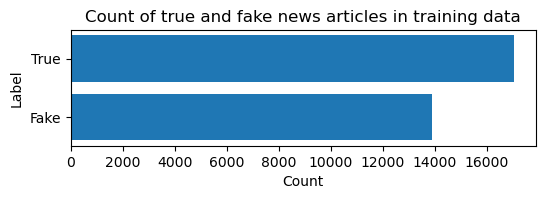

In [32]:
# alt.data_transformers.enable('vegafusion')

# count_chart = alt.Chart(train_df).mark_bar().encode(
#     x=alt.X('count():Q', title='Count'),
#     y=alt.Y('target:N', title='Label'),
#     color=alt.Color('target:N', title='News Type')
# ).properties(
#     title='Count of True and Fake News Articles in Training Data',
#     height=50,
#     width=500
# )

counts = train_df['target'].value_counts().sort_index()

plt.figure(figsize=(6, 1.5)) 
plt.barh(counts.index, counts.values)

# Labels and title
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Count of true and fake news articles in training data')

plt.show()

In [33]:
train_df['target'].value_counts()

target
True    17027
Fake    13885
Name: count, dtype: int64

From figure 1, we can see that the training dataset is fairly balanced, with 13,885 fake news articles and 17,027 real news articles. This balance may help to prevent bias towards one class over the other when training our model.

In [34]:
fake_text = train_df[train_df['target'] == 'Fake']['text']
true_text = train_df[train_df['target'] == 'True']['text']

# Remove "'s" instances (possessives/contractions)
fake_text = fake_text.str.replace(r"\bs\b", "", regex=True)
true_text = true_text.str.replace(r"\bs\b", "", regex=True)

# remove punctuation
fake_text = fake_text.str.replace(r'[^\w\s]', '', regex=True)
true_text = true_text.str.replace(r'[^\w\s]', '', regex=True)

fake_words = fake_text.str.cat(sep=" ")
true_words = true_text.str.cat(sep=" ")

fake_titles = train_df[train_df['target'] == 'Fake']['title']
true_titles = train_df[train_df['target'] == 'True']['title']

# remove punctuation
fake_titles = fake_titles.str.replace(r'[^\w\s]', '', regex=True)
true_ttitles = true_titles.str.replace(r'[^\w\s]', '', regex=True)

# Remove "'s" instances (possessives/contractions)
fake_titles = fake_titles.str.replace(r"\bs\b", "", regex=True)
true_titles = true_titles.str.replace(r"\bs\b", "", regex=True)

fake_title_words = fake_titles.str.cat(sep=" ")
true_title_words = true_titles.str.cat(sep=" ")

#### Word Clouds for Titles Column

Figure 2: Word cloud for titles of fake news articles

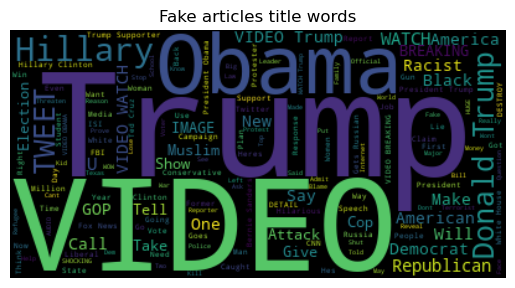

In [35]:
wordcloud_title_fake = WordCloud().generate(fake_title_words)
plt.figure()
plt.imshow(wordcloud_title_fake, interpolation="bilinear")
plt.title("Fake articles title words")
plt.axis("off")
plt.show()

Figure 3: Word cloud for titles of true news articles

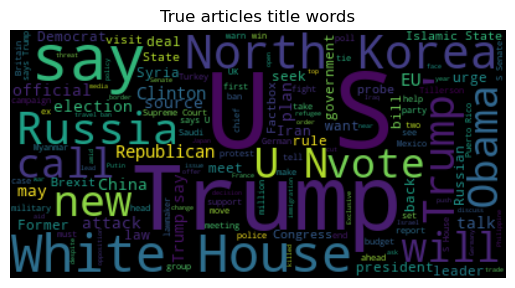

In [36]:
wordcloud_title_true = WordCloud().generate(true_title_words)
plt.figure()
plt.imshow(wordcloud_title_true, interpolation="bilinear")
plt.title("True articles title words")
plt.axis("off")
plt.show()

The most prominent words in the fake news titles include "VIDEO", "Trump" and "Obama". The most common words in the true news titles include "Trump", "US" and "White House".

We can see that "Trump" appears frequently in both fake and true news titles, which means that it may not give much discriminatory power when classifying articles. However, words like "VIDEO", that appear much more frequently in fake news titles, may help the model identify fake news articles.

#### Word Clouds for Text Column

Figure 4: Word cloud for text of fake news articles

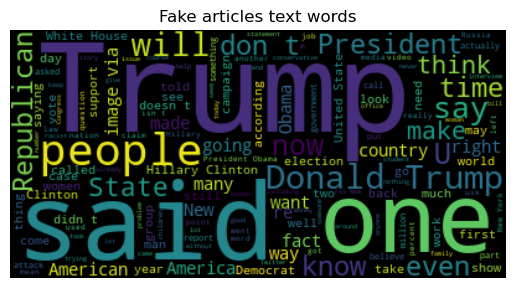

In [37]:
wordcloud_fake = WordCloud().generate(fake_words)
plt.figure()
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.title("Fake articles text words")
plt.axis("off")
plt.show()

Figure 5: Word cloud for text of true news articles

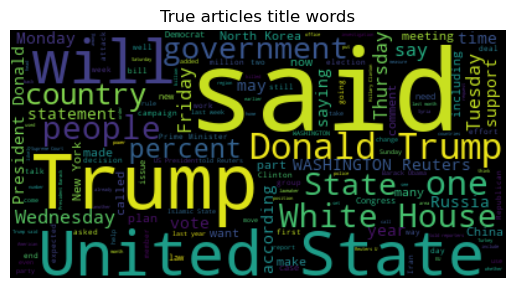

In [38]:
wordcloud_true = WordCloud().generate(true_words)
plt.figure()
plt.imshow(wordcloud_true, interpolation="bilinear")
plt.title("True articles title words")
plt.axis("off")
plt.show()

The most commonly used words in the body text of fake news articles include "Trump", "said", and "one". The most frequent words in true news articles are "Trump", "said", and "United State". Given that there is more overlap in the common words used in the body text of fake and true news articles compared to the titles, the titles may provide more distinctive features for classification.

#### Comparing title and text length between fake and real news articles

In [39]:
train_df["title_length"] = train_df["title"].str.len()
train_df["text_length"] = train_df["text"].str.len()

Figure 6: Distribution of article titles for fake and true news articles

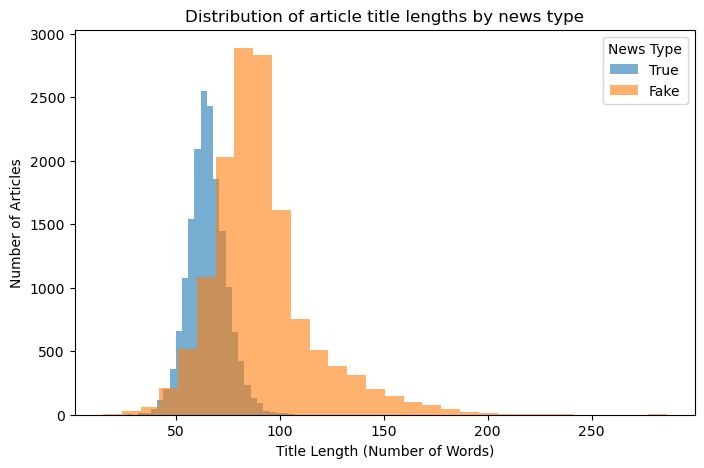

In [40]:
bins = 30
plt.figure(figsize=(8, 5))

for label in train_df['target'].unique():
    subset = train_df[train_df['target'] == label]
    plt.hist(subset['title_length'],
             bins=bins,
             alpha=0.6,
             label=str(label))

plt.xlabel('Title Length (Number of Words)')
plt.ylabel('Number of Articles')
plt.title('Distribution of article title lengths by news type')
plt.legend(title='News Type')

plt.show()

Figure 7: Distribution of article text length for fake and true news articles

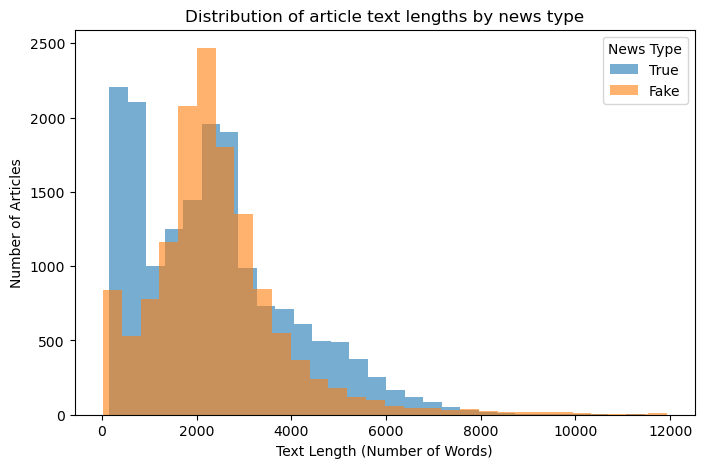

In [41]:
filtered_df = train_df[train_df['text_length'] < 12000]

bins = 30
plt.figure(figsize=(8, 5))

for label in filtered_df['target'].unique():
    subset = filtered_df[filtered_df['target'] == label]
    plt.hist(
        subset['text_length'],
        bins=bins,
        alpha=0.6,
        label=str(label)
    )

plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Number of Articles')
plt.title('Distribution of article text lengths by news type')
plt.legend(title='News Type')

plt.show()

From figure 6, we can see that the length of true news titles appears to have bell-shaped distribution, while the length of fake news titles is right-skewed. This suggests that if the title of a news article is particularly long, it may be more likely to be fake news. This strategy may be utilized to grab readers' attention with sensational or clickbait-style headlines.

When comparing the body text lengths, we can see that both fake and true news articles have right-skewed distributions. Their distributions are quite similar, indicating that body text length may not be a strong indicator of whether an article is fake or true news.

#### Comparing the percentage of counts of subjects between fake and real news articles

Figure 8: Comparing the percentage of counts of subjects between fake and true news articles

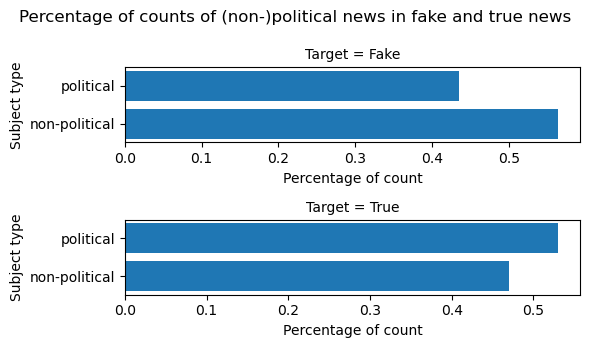

In [42]:
number_of_fake = train_df[train_df['target'] == 'Fake'].shape[0]
number_of_true = train_df[train_df['target'] == 'True'].shape[0]
plot_df = train_df.groupby(['target', 'subject']).size().reset_index()
plot_df.columns = ['target', 'subject', 'count']
plot_df.loc[plot_df['target'] == 'Fake', 'total'] = number_of_fake
plot_df.loc[plot_df['target'] == 'True', 'total'] = number_of_true
plot_df['percentage'] = plot_df['count'] / plot_df['total']

targets = plot_df['target'].unique()
num_targets = len(targets)

fig, axes = plt.subplots(
    nrows=num_targets,
    ncols=1,
    figsize=(6, 3.5))

if num_targets == 1:
    axes = [axes]

for ax, tgt in zip(axes, targets):
    subset = plot_df[plot_df['target'] == tgt]
    ax.barh(
        subset['subject'],
        subset['percentage'],
        color=None
    )
    ax.set_title(f"Target = {tgt}", fontsize=10) 
    ax.set_ylabel("Subject type", fontsize=10)
    ax.set_xlabel("Percentage of count", fontsize=10)

plt.suptitle(
    "Percentage of counts of (non-)political news in fake and true news",
    fontsize=12
)

plt.tight_layout()
plt.show()

As shown in the faceted bar plot above, non-political news accounts for a larger portion of the fake news, while there is a larger percentage of political news in the true news. The difference of percentages exists but is not conspicuous, suggesting this engineered feature `subject` may still be useful in predicting whether news is true. Therefore, the feature `subject` (political vs non-political) is included in the classification model below.

#### Classfication Modeling Analysis

##### Dummy Classifier

The dummy classifier acts as the baseline before building a more advanced model. The strategy used is `"most_frequent"` so that the dummy classifier always predicts the majority class. The goal later on is to build a classification model that does well compared to this dummy.

##### Naive Bayes Classifier

`MultinomialNB` is used as the estimator to deal with integer counts data, after proper preprocessing of the features. Two textual features (`title` and `text`) and a categorical feature `subject` with only two levels (political and non-political) are included in modelling. The `date` feature is dropped due to its irrelevance to the target. Genereally speaking, when the news is published is random information and has little to do with whether the news is fake or true.

As a first step, the features should be preprocessed. One-Hot encoding is applied to the categorical feature `subject` with `drop="if_binary"` to include only one column for this binary feature. For the two textual features, `title` and `text`, they are first transformed by `lambda x: np.ravel(x)` to be one-dimensional arrays. After being flattened, they are then passed to `CountVectorizer` to extract the words and number of occurrences from these two features. Note that `CountVectorizer` needs to be created twice, one for each textual feature.

Next, a machine learning pipeline `pipe` is created, with preprocessing and the Naive Bayes estimator.

Before fitting the model to the training set, hyperparameter tuning is carried out to boost classification performance. There are 3 hyperparameters being considered: `max_feautres` of the two `CountVectorizer`s, and `alpha` of `MultinomialNB`. The distributions of these hyperparameters to search from are specified below, followed by `RandomizedSearchCV` to do random search and cross validation. 

Note that `RandomizedSearchCV` runs very slowly in this case. To reduce computation time, `n_iter` is set to only 10. Albeit doing only 10 searches, the best model found already performs very well, as we can see from the CV score and test scores below.

## Results

Using most frequent dummy classifier, the test score is low (only 0.54) due to a relatively balanced dataset.

In [43]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_test, y_test)

0.5412084357614181

Now compare the Naive Bayes model with the dummy classifier. After fitting the Naive Bayes model to the training set, the best hyperparameters and CV score can be extracted from the model. The best values of all 3 hyperparameters are in the middle of the search ranges instead of being on the edge, so the search ranges are specified appropriately. Under this model, the training score is 0.956. The best CV score is 0.955, and the test score is 0.954. Since the train, CV and test score are close to one another and are both high, underfitting or overfitting is not a concern here. Compared to dummy classifier, this Naive Bayes model performs a lot better in terms of prediction accuracy, increasing the test score from 0.54 to 0.95.

In [44]:
title_feature = 'title'
text_feature = 'text'
categorical_feature = ['subject']
drop_feature = ['date']

title_pipe = make_pipeline(
    FunctionTransformer(lambda x: np.ravel(x)), 
    CountVectorizer()
)
text_pipe = make_pipeline(
    FunctionTransformer(lambda x: np.ravel(x)), 
    CountVectorizer()
)

preprocessor = ColumnTransformer(
    [
        ("one_hot", OneHotEncoder(drop="if_binary"), categorical_feature),
        ("title_vectorizer", title_pipe, "title"),
        ("text_vectorizer", text_pipe, "text"),
        ("drop", "drop", drop_feature)
    ]
)

pipe = make_pipeline(preprocessor, MultinomialNB())

In [45]:
param_dist = {
    "columntransformer__title_vectorizer__countvectorizer__max_features": randint(1, 200),
    "columntransformer__text_vectorizer__countvectorizer__max_features": randint(1, 5000),
    "multinomialnb__alpha": 10.0 ** np.arange(-7, 1)
}

random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=param_dist, 
                                   n_iter=10, n_jobs=-1,
                                   return_train_score=True,
                                   random_state=123) 

In [46]:
random_search.fit(X_train, y_train)
random_search.best_params_

{'columntransformer__text_vectorizer__countvectorizer__max_features': 4144,
 'columntransformer__title_vectorizer__countvectorizer__max_features': 74,
 'multinomialnb__alpha': np.float64(1e-07)}

In [47]:
random_search.score(X_train, y_train)

0.9555512422360248

In [48]:
random_search.best_score_

np.float64(0.954548484110715)

In [49]:
random_search.score(X_test, y_test)

0.953939707594773

Below are the visualizations of the classification results on the test set, as a model performance assessment.

Figure 9: Confusion matrix for Naive Bayes classifier on test set

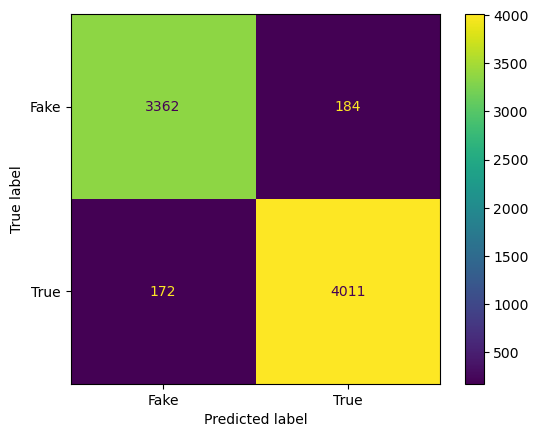

In [50]:
ConfusionMatrixDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    values_format="d"
)

In [51]:
print(
    classification_report(
        y_test, random_search.predict(X_test)
    )
)

              precision    recall  f1-score   support

        Fake       0.95      0.95      0.95      3546
        True       0.96      0.96      0.96      4183

    accuracy                           0.95      7729
   macro avg       0.95      0.95      0.95      7729
weighted avg       0.95      0.95      0.95      7729



The model classifies both true and fake news correctly most of the time, indicated by o a high true postive and true negative rate. Both false positve and false negative rates are low, since there are few misclassifications. Therefore, not only is the model accuracy high, but the model is also robust in correctly detecting both true and fake news, with few misclassifications.

Figure 10: Precision-Recall curve for Naive Bayes classifier on test set

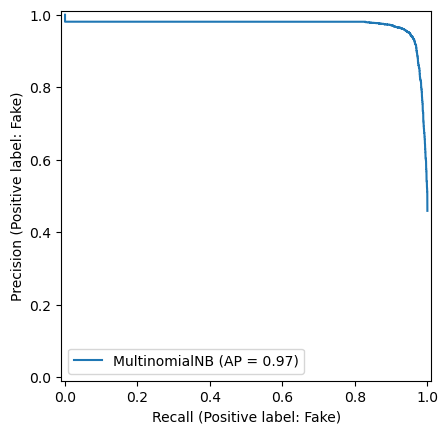

In [52]:
PrecisionRecallDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    pos_label='Fake',
    name='MultinomialNB'
)

The AP score, as a summary of the PR curve, is 0.97. That fact that the AP score is very close to 1 suggests that our Naive Bayes model's performance is excellent.

Figure 11: ROC Curve for Naive Bayes classifier on test set

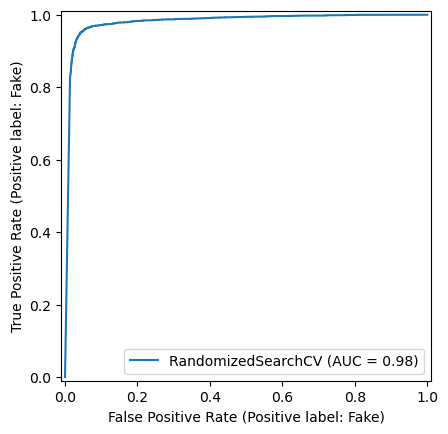

In [53]:
RocCurveDisplay.from_estimator(
    random_search,
    X_test,
    y_test,
    pos_label='Fake'
)

The AUC here is 0.98, which is much higher than the baseline 0.5, further indicating the satisfactory performance of the Naive Bayes model.

## Discussion

#### Result summary

The Naive Bayes model performs decently well due to high accuracy, high true positive rate, high true negative rate, low false postive rate, low false negative rate, high AP score and high AUC value. Apart from these exceptional evaluation metrics, this model also does not throw major concerns such as underfitting or overfitting problems. The training score (0.956), the best CV score (0.955), and test score (0.954) are consistently high and close to one another, so there is no noticeable underfitting or overfitting issue. To summarize, compared to the baseline model (dummy classifier), this Naive Bayes model exhibits major improvements, returning satisfactory results.

#### Discuss whether this is what we expected to find

Yes and No.

According to the nature of political news, it is expected that there are much more political news under the fake news category. However, in this dataset, there are only 2% more political news in fake news compared to true news. This marginal difference is not expected. 

However, Naive Bayes model generally yields high performance despite its simplicity. So, using `MultinomialNB` with hyperparameter tuning gives an expected high prediction performance. Moreover, the original counts of words are used instead of the binary information presence/absence, so there is no loss of information in modelling. Therefore, the satisfactory result is as expected.

#### Discuss the impacts of these findings

This Naive Bayes model could potentially be deployed and used for news classification, which helps news readers identify fake news and avoid accepting false information. Secondly, this news classification model could also assist news agents screen and select only the true news to publish, avoiding losing reputation for articulating fake news. Lastly, this model could inspire further improvements of news classification models, acting as a good starting point for future model building.

#### Discuss what future questions could this lead to

Specific to this particular model, two future questions could be asked. First, the percentage of counts of political news is only marginally different between true and fake news. So, it is worth exploring whether dropping the `subject` feature will increase or decrease the model performance. This can be done by comparing the two models with and without the `subject` feature. Second, what other possible features can be used or engineered to further improve the model performance? This can be explored by asking for suggestions from human experts with domain knowledge. So far only the Naive Bayes model is used, which is a simple and naive model. Not restricted to this model anymore, there are other questions that can be raised. For example, are there any other more advanced models that can deal with integer count data and have more satisfying results?

#### Limitations of analysis

All news are classified as political and non-political in the analysis, which is crude and leaves space for improvement. More detailed `subject` categories can be applied to improve model performance. Besides that, all the collected data we have do not cover all types of news in the world. The topics included in the dataset are rather quite limited. So, this model could do well when seeing similar news, but could fail when given a totally unfamiliar news topic. So enriching the training data is essential to deploy the model in the wild.

## References

Service Canada, (2024, January 10). Learn about it. Www.canada.ca. https://www.canada.ca/en/campaign/online-disinformation/learn-about-it.html.

Bilodeau, Howard, and Aisha Khalid. “The Spread of Misinformation: A Multivariate Analysis of the Relationship between Individual Characteristics and Fact-Checking Behaviours of Canadians.” Statcan.gc.ca, Government of Canada, Statistics Canada, 25 July 2024, [www150.statcan.gc.ca/n1/pub/22-20-0001/222000012024003-eng.htm](https://www150.statcan.gc.ca/n1/pub/22-20-0001/222000012024003-eng.htm).

Pennycook, Gordon, and David G. Rand. “The Psychology of Fake News.” Trends in Cognitive Sciences, vol. 25, no. 5, May 2021, pp. 388–402, https://doi.org/10.1016/j.tics.2021.02.007.

Allcott, Hunt, and Matthew Gentzkow. “Social Media and Fake News in the 2016 Election.” Journal of Economic Perspectives, vol. 31, no. 2, 2017, pp. 211–236, www.aeaweb.org/articles?id=10.1257/jep.31.2.211, https://doi.org/10.1257/jep.31.2.211.

clmentbisaillon. “Fake and Real News Dataset.” Www.kaggle.com, [www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset).

